# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
import numpy as np 
import scipy.stats as st
import emcee
import corner
import george
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

In [2]:
%matplotlib inline

from astropy.table import Table
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


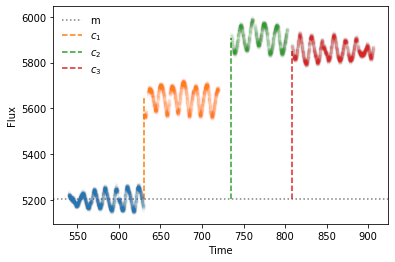

In [4]:
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)


In [5]:
# Oscillation completes full cycle/period in ~50/3 or 16.666 days.
# "P" Param is really log_P, so...
np.log(50/3)

2.8134107167600364

In [6]:
print(means) #m, c1, c2, c3

[5203.7993840014005, 5643.826820751147, 5906.00942404101, 5852.1877312730585]


### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

In [66]:
# let's conjure up some priors for our 8 params

A_prior = st.norm(loc=10,scale=5) #on George documentation some kernels had a value of 5 or 10 so sure
G1_prior = st.norm(loc=0.1,scale=1) #on George doc some kernels had this value of 0.1 but idk why but i guess it's fine
logP_prior = st.norm(loc=50/3,scale=2.813) #values from above 
Lam_prior = st.norm(loc=100,scale=25) # amplitude of oscillations?
m_prior = st.norm(loc=means[0],scale=10) #get means from above code (thanks Gautham!)
c1_prior = st.norm(loc=means[1]-means[0],scale=20) #want diff cause we need offset to renormalize flux
c2_prior = st.norm(loc=means[2]-means[1],scale=20) #scale is guess from plot
c3_prior = st.norm(loc=means[3]-means[2],scale=20)


In [67]:
#for kernel values, I'll need some drawn value from their distribution

init_A = A_prior.rvs(1)[0] 
init_G1 = G1_prior.rvs(1)[0]
init_logP = logP_prior.rvs(1)[0]
init_Lam = Lam_prior.rvs(1)[0]

print(init_A, init_G1, init_logP, init_Lam)

11.058727921342063 1.5944743028307922 16.342022619863013 131.28826196829738


In [68]:
# if i mulitply kernels, arguments in their exponents add, 
# which is what i want to get desired k(t_i, t_j) kernel equation above
from george import kernels

k1 = kernels.ExpSquaredKernel(metric=init_Lam) #is this -1 or 1?
k2 = init_A * kernels.ExpSine2Kernel(gamma=init_G1, log_period=init_logP)
k = k1 + k2
print(k)

ExpSquaredKernel(metric=Metric(131.2882619682974, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None) + ConstantKernel(log_constant=2.403219973325803, ndim=1, axes=array([0])) * ExpSine2Kernel(gamma=1.5944743028307922, log_period=16.342022619863013, ndim=1, axes=array([0]))


This is my kernel for my quasi-periodic oscillation model :)

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

In [69]:
from george.modeling import Model
import pandas as pd

In [70]:
class MeanModel(Model):
    parameter_names = ("m","c1","c2","c3")
    
    #make sure this matches w/ correct order
    def set_vector(self,w):
        self.m = w[0]
        self.c1 = w[1]
        self.c2 = w[2]
        self.c3 = w[3]

    global q_dict
    global day
    global qtr 
    global q_indx
    global time
    global q_indx_vec
    global means_dict
    
    q_dict = {}
    day = tab['time']
    qtr = tab['quarter']
    
    for time,q_indx in zip(day,qtr):
        q_dict[time] = q_indx
        time_vec = np.vectorize(time)
        q_indx_vec = np.vectorize(q_dict.get)
        #print(time_vec, q_indx_vec) 
        
    def get_value(self,t):
        means_dict = {6:self.m,
                     7:self.c1+self.m,
                     8:self.c2+self.m,
                     9:self.c3+self.m}
        means_dict_vec = np.vectorize(means_dict.get)
        
        q_indx = q_indx_vec(t)
        #print(q_indx)
        value = means_dict_vec(q_indx)
        #print(value)
        return value

mm = MeanModel

In [71]:
mm(means[0],means[1]-means[0],means[2]-means[0],means[3]-means[0]).get_value(t)

array([5203.799384  , 5203.799384  , 5203.799384  , ..., 5852.18773127,
       5852.18773127, 5852.18773127])

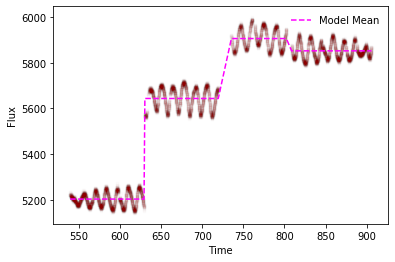

In [72]:
plt.plot(t, mm(w[0],w[1],w[2],w[3]).get_value(t), color='magenta', ls='--', label='Model Mean')
plt.scatter(t, y, color='darkred', marker='.', alpha=0.01)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)

Ok cool this matches ok. Now for George

In [73]:
#from doc, classgeorge.GP(kernel, mean=None, solver=<class 'george.basic.BasicSolver'>, **kwargs) so

model = george.GP(k, mean=mm(means[0],means[1]-means[0],means[2]-means[0],means[3]-means[0]))


In [92]:
t = np.array(day)
y = np.array(tab['flux'])
yerr = np.array(tab['error'])

model.compute(t[::40], yerr[::40])

In [75]:
model.get_parameter_names()

('mean:m',
 'mean:c1',
 'mean:c2',
 'mean:c3',
 'kernel:k1:metric:log_M_0_0',
 'kernel:k2:k1:log_constant',
 'kernel:k2:k2:gamma',
 'kernel:k2:k2:log_period')

In [76]:
#my 8 model param vector is
w = model.get_parameter_vector()
print(w)

[5.20379938e+03 4.40027437e+02 7.02210040e+02 6.48388347e+02
 4.87739538e+00 2.40321997e+00 1.59447430e+00 1.63420226e+01]


In [77]:
#so m = w[0], c1 = w[1]....logP = w[7]
#put this info in log_prior func

def log_prior(w):
    
    model.set_parameter_vector(w)
    
    #make sure to match up model names correctly!!!!!
    m_w    = w[0]
    c1_w   = w[1]
    c2_w   = w[2]
    c3_w   = w[3]
    Lam_w  = w[4] 
    A_w    = w[5]
    G1_w   = w[6]
    logP_w = w[7]
    
    # prior on m (flux)
    # be within reasonable range from plot
    if m_w >= 10000 or m_w <= 2000:
        return -np.inf

    # prior on nuisance params 
    # def some offset but can't be ridiculously big
    if (c1_w < 100) or (c1_w > 10000):
        return -np.inf
    
    # prior on nuisance params
    if (c2_w < 100) or (c2_w > 1000):
        return -np.inf
    
    # prior on nuisance params
    if (c3_w < 100) or (c3_w > 1000):
        return -np.inf
    
    # prevent other 4 params from being ridicuous too
    # i guess they can be negative (except logP, A)
    if (Lam_w <= -20) or (Lam_w > 20):
        return -np.inf
    
    #can't be neg or else kernel is busted
    if (A_w  <= 0) or (A_w > 100):
        return -np.inf
    
    if (G1_w  <= -100) or (G1_w > 100):
        return -np.inf
    
    #the thought of negative log period lol
    if (logP_w  <= 0) or (logP_w > 30):
        return -np.inf
    
    #make log prior of each param
    log_m_w = np.log(m_prior.pdf(m_w))
    log_c1_w = np.log(c1_prior.pdf(c1_w))
    log_c2_w = np.log(c2_prior.pdf(c2_w))
    log_c3_w = np.log(c3_prior.pdf(c3_w))
    log_Lam_w = np.log(Lam_prior.pdf(Lam_w))
    log_A_w = np.log(A_prior.pdf(A_w))
    log_G1_w = np.log(G1_prior.pdf(G1_w))
    log_logP_w = np.log(logP_prior.pdf(logP_w))
    
    log_arr_w = np.array([log_m_w, log_c1_w, log_c2_w, log_c3_w, log_Lam_w, log_A_w, log_G1_w, log_logP_w])
    # sum the log priors
    logp = np.sum(log_arr_w)
    print(A_prior)
    return logp 
    

In [78]:
print("My log prior value is...", log_prior(w))

My log prior value is... -892.4239677699833


### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

In [79]:
#straight from George doc website

def neg_ln_like(w):
    model.set_parameter_vector(w)
    return -model.log_likelihood(y[::40])

def grad_neg_ln_like(w):
    model.set_parameter_vector(w)
    return -model.grad_log_likelihood(y[::40])

result = minimize(neg_ln_like, model.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

model.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(model.log_likelihood(y[::40])))

      fun: 11474.283263553782
 hess_inv: array([[ 2.44805677e-01, -2.35468563e-01, -2.30651442e-01,
        -2.07062040e-01, -4.49013162e-05, -4.05398856e-01,
        -3.76562418e-08,  1.20083810e-07],
       [-2.35468563e-01,  5.41651202e-01,  2.17770504e-01,
         1.97547756e-01, -3.98306523e-04,  4.37640974e-01,
         4.32477033e-08, -1.37914694e-07],
       [-2.30651442e-01,  2.17770504e-01,  6.11913482e-01,
         2.06203135e-01, -5.78298441e-04,  4.10961780e-01,
         3.58028050e-08, -1.14173285e-07],
       [-2.07062040e-01,  1.97547756e-01,  2.06203135e-01,
         3.65314400e-01,  7.00076261e-04,  6.72420953e-01,
         5.82543898e-08, -1.85770248e-07],
       [-4.49013162e-05, -3.98306523e-04, -5.78298441e-04,
         7.00076261e-04,  1.44719120e-03, -4.32980894e-03,
        -1.05240890e-09,  3.35607792e-09],
       [-4.05398856e-01,  4.37640974e-01,  4.10961780e-01,
         6.72420953e-01, -4.32980894e-03,  2.34094378e+05,
         2.67488739e-02, -8.53007809

In [80]:
def lnprob(w):
    model.set_parameter_vector(w)
    
    #posterior is loglike + logprior
    return model.log_likelihood(y[::40], quiet=True) + log_prior(w)

print(model.log_likelihood(y[::40], quiet=True))
print(log_prior(w))

-11474.283263553782
-892.4239677699833


In [81]:
#THE POSTERIOR!!!
lnprob(w)

-13935.835965927745

In [82]:
#is this value good? idk...

/Users/patrickaleo/miniconda3/envs/fds/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


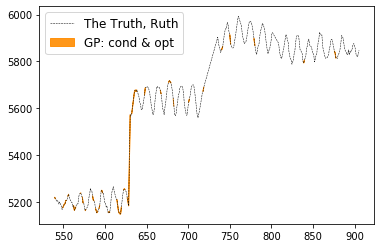

In [100]:
import scipy.optimize as op

model = george.GP(k, mean=mm(means[0],means[1]-means[0],means[2]-means[0],means[3]-means[0]))
model.compute(t[::40])

# Run optimization routine.
p0 = model.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
model.set_parameter_vector(results.x)

#for predicting new offset dataset
y_pred, cov = model.predict(y[::40], t[::40], return_cov=True)
std = np.sqrt(np.diag(cov))

plt.fill_between(t[::40], y_pred+std, y_pred-std, color="darkorange", alpha=0.9, label='GP: cond & opt')
plt.plot(t[::40], y[::40], 'k', ls='--', lw=0.5, label='The Truth, Ruth')
plt.legend(loc='best', fontsize=12)

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [84]:
import emcee

# Set up the sampler.
nwalkers, ndim = 16, 8
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob);
step_n = 500
nburnin = 100

# Initialize the walkers.
w0 = model.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers, ndim);
print(log_prior(w0[0,:]))

# run a burn-in 
refine = sampler.run_mcmc(w0, nburnin, progress=True)
burn = sampler.get_chain()
sampler.reset()

print("Running production chain")
sampler.run_mcmc(refine, step_n, progress=True);

  0%|          | 0/100 [00:00<?, ?it/s]

-893.3331925132012


  1%|          | 1/100 [00:00<00:17,  5.61it/s]

  2%|▏         | 2/100 [00:00<00:17,  5.69it/s]

  3%|▎         | 3/100 [00:00<00:16,  5.85it/s]

  4%|▍         | 4/100 [00:00<00:17,  5.63it/s]

  5%|▌         | 5/100 [00:00<00:18,  5.06it/s]

  7%|▋         | 7/100 [00:01<00:16,  5.62it/s]

  8%|▊         | 8/100 [00:01<00:17,  5.34it/s]

  9%|▉         | 9/100 [00:01<00:17,  5.31it/s]

 10%|█         | 10/100 [00:01<00:17,  5.20it/s]

 11%|█         | 11/100 [00:02<00:15,  5.58it/s]

 13%|█▎        | 13/100 [00:02<00:13,  6.28it/s]

 14%|█▍        | 14/100 [00:02<00:13,  6.56it/s]

 16%|█▌        | 16/100 [00:02<00:12,  6.75it/s]

 17%|█▋        | 17/100 [00:02<00:12,  6.75it/s]

 19%|█▉        | 19/100 [00:03<00:11,  6.91it/s]

 20%|██        | 20/100 [00:03<00:11,  6.98it/s]

 22%|██▏       | 22/100 [00:03<00:10,  7.21it/s]

 23%|██▎       | 23/100 [00:03<00:10,  7.23it/s]

 25%|██▌       | 25/100 [00:03<00:10,  7.36it/s]

 26%|██▌       | 26/100 [00:04<00:10,  7.33it/s]

 28%|██▊       | 28/100 [00:04<00:09,  7.42it/s]

 29%|██▉       | 29/100 [00:04<00:09,  7.34it/s]

 31%|███       | 31/100 [00:04<00:09,  7.24it/s]

 33%|███▎      | 33/100 [00:05<00:09,  7.31it/s]

 34%|███▍      | 34/100 [00:05<00:08,  7.34it/s]

 36%|███▌      | 36/100 [00:05<00:08,  7.41it/s]

 37%|███▋      | 37/100 [00:05<00:08,  7.41it/s]

 39%|███▉      | 39/100 [00:05<00:08,  7.11it/s]

 40%|████      | 40/100 [00:06<00:08,  7.14it/s]

 42%|████▏     | 42/100 [00:06<00:07,  7.29it/s]

 43%|████▎     | 43/100 [00:06<00:07,  7.20it/s]

 45%|████▌     | 45/100 [00:06<00:07,  7.24it/s]

 46%|████▌     | 46/100 [00:06<00:07,  7.32it/s]

 48%|████▊     | 48/100 [00:07<00:07,  7.42it/s]

 49%|████▉     | 49/100 [00:07<00:06,  7.35it/s]

 51%|█████     | 51/100 [00:07<00:06,  7.39it/s]

 52%|█████▏    | 52/100 [00:07<00:06,  7.33it/s]

 54%|█████▍    | 54/100 [00:07<00:06,  7.43it/s]

 56%|█████▌    | 56/100 [00:08<00:05,  7.51it/s]

 57%|█████▋    | 57/100 [00:08<00:05,  7.49it/s]

 59%|█████▉    | 59/100 [00:08<00:05,  7.54it/s]

 60%|██████    | 60/100 [00:08<00:05,  7.36it/s]

 62%|██████▏   | 62/100 [00:09<00:05,  7.24it/s]

 63%|██████▎   | 63/100 [00:09<00:05,  7.33it/s]

 64%|██████▍   | 64/100 [00:09<00:05,  7.10it/s]

 66%|██████▌   | 66/100 [00:09<00:05,  6.69it/s]

 67%|██████▋   | 67/100 [00:09<00:04,  6.86it/s]

 69%|██████▉   | 69/100 [00:10<00:04,  7.02it/s]

 70%|███████   | 70/100 [00:10<00:04,  7.11it/s]

 72%|███████▏  | 72/100 [00:10<00:03,  7.25it/s]

 73%|███████▎  | 73/100 [00:10<00:04,  6.64it/s]

 74%|███████▍  | 74/100 [00:10<00:04,  6.33it/s]

 76%|███████▌  | 76/100 [00:11<00:03,  6.68it/s]

 77%|███████▋  | 77/100 [00:11<00:03,  6.87it/s]

 79%|███████▉  | 79/100 [00:11<00:02,  7.17it/s]

 80%|████████  | 80/100 [00:11<00:02,  7.16it/s]

 82%|████████▏ | 82/100 [00:11<00:02,  7.11it/s]

 84%|████████▍ | 84/100 [00:12<00:02,  7.32it/s]

 85%|████████▌ | 85/100 [00:12<00:02,  7.28it/s]

 87%|████████▋ | 87/100 [00:12<00:01,  7.43it/s]

 88%|████████▊ | 88/100 [00:12<00:01,  7.32it/s]

 89%|████████▉ | 89/100 [00:12<00:01,  6.88it/s]

 91%|█████████ | 91/100 [00:13<00:01,  7.11it/s]

 93%|█████████▎| 93/100 [00:13<00:00,  7.37it/s]

 94%|█████████▍| 94/100 [00:13<00:00,  7.37it/s]

 96%|█████████▌| 96/100 [00:13<00:00,  7.48it/s]

 97%|█████████▋| 97/100 [00:13<00:00,  7.38it/s]

 99%|█████████▉| 99/100 [00:14<00:00,  7.35it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running production chain


  0%|          | 2/500 [00:00<01:11,  6.95it/s]

  1%|          | 3/500 [00:00<01:10,  7.04it/s]

  1%|          | 5/500 [00:00<01:07,  7.32it/s]

  1%|          | 6/500 [00:00<01:07,  7.36it/s]

  2%|▏         | 8/500 [00:01<01:06,  7.43it/s]

  2%|▏         | 9/500 [00:01<01:06,  7.36it/s]

  2%|▏         | 11/500 [00:01<01:06,  7.40it/s]

  3%|▎         | 13/500 [00:01<01:04,  7.60it/s]

  3%|▎         | 14/500 [00:01<01:04,  7.49it/s]

  3%|▎         | 16/500 [00:02<01:04,  7.53it/s]

  3%|▎         | 17/500 [00:02<01:05,  7.35it/s]

  4%|▍         | 19/500 [00:02<01:05,  7.37it/s]

  4%|▍         | 20/500 [00:02<01:13,  6.52it/s]

  4%|▍         | 21/500 [00:03<01:26,  5.53it/s]

  4%|▍         | 22/500 [00:03<01:20,  5.92it/s]

  5%|▍         | 23/500 [00:03<01:16,  6.27it/s]

  5%|▍         | 24/500 [00:03<01:24,  5.60it/s]

  5%|▌         | 26/500 [00:03<01:20,  5.89it/s]

  5%|▌         | 27/500 [00:03<01:15,  6.30it/s]

  6%|▌         | 28/500 [00:04<01:18,  6.02it/s]

  6%|▌         | 30/500 [00:04<01:17,  6.07it/s]

  6%|▌         | 31/500 [00:04<01:14,  6.33it/s]

  6%|▋         | 32/500 [00:04<01:11,  6.54it/s]

  7%|▋         | 34/500 [00:05<01:10,  6.61it/s]

  7%|▋         | 35/500 [00:05<01:14,  6.24it/s]

  7%|▋         | 36/500 [00:05<01:17,  6.01it/s]

  8%|▊         | 38/500 [00:05<01:12,  6.41it/s]

  8%|▊         | 39/500 [00:05<01:14,  6.17it/s]

  8%|▊         | 40/500 [00:06<01:32,  4.98it/s]

  8%|▊         | 41/500 [00:06<01:36,  4.76it/s]

  8%|▊         | 42/500 [00:06<01:43,  4.42it/s]

  9%|▉         | 44/500 [00:07<01:34,  4.84it/s]

  9%|▉         | 46/500 [00:07<01:35,  4.75it/s]

  9%|▉         | 47/500 [00:07<01:28,  5.11it/s]

 10%|▉         | 48/500 [00:07<01:20,  5.58it/s]

 10%|█         | 50/500 [00:08<01:23,  5.40it/s]

 10%|█         | 51/500 [00:08<01:20,  5.58it/s]

 10%|█         | 52/500 [00:08<01:31,  4.88it/s]

 11%|█         | 53/500 [00:08<01:21,  5.48it/s]

 11%|█         | 55/500 [00:09<01:10,  6.29it/s]

 11%|█         | 56/500 [00:09<01:08,  6.47it/s]

 12%|█▏        | 58/500 [00:09<01:05,  6.71it/s]

 12%|█▏        | 59/500 [00:09<01:04,  6.87it/s]

 12%|█▏        | 61/500 [00:09<01:01,  7.13it/s]

 12%|█▏        | 62/500 [00:10<01:02,  6.97it/s]

 13%|█▎        | 64/500 [00:10<01:03,  6.90it/s]

 13%|█▎        | 65/500 [00:10<01:02,  7.01it/s]

 13%|█▎        | 67/500 [00:10<01:00,  7.15it/s]

 14%|█▎        | 68/500 [00:10<01:00,  7.08it/s]

 14%|█▍        | 70/500 [00:11<00:59,  7.17it/s]

 14%|█▍        | 71/500 [00:11<01:00,  7.11it/s]

 15%|█▍        | 73/500 [00:11<00:59,  7.21it/s]

 15%|█▍        | 74/500 [00:11<00:59,  7.21it/s]

 15%|█▌        | 76/500 [00:12<00:57,  7.31it/s]

 15%|█▌        | 77/500 [00:12<00:58,  7.20it/s]

 16%|█▌        | 79/500 [00:12<00:58,  7.25it/s]

 16%|█▌        | 80/500 [00:12<00:58,  7.19it/s]

 16%|█▋        | 82/500 [00:12<00:58,  7.16it/s]

 17%|█▋        | 83/500 [00:12<00:58,  7.14it/s]

 17%|█▋        | 85/500 [00:13<00:58,  7.14it/s]

 17%|█▋        | 86/500 [00:13<00:59,  6.99it/s]

 18%|█▊        | 88/500 [00:13<00:59,  6.95it/s]

 18%|█▊        | 89/500 [00:13<00:57,  7.09it/s]

 18%|█▊        | 91/500 [00:14<01:00,  6.79it/s]

 18%|█▊        | 92/500 [00:14<01:00,  6.71it/s]

 19%|█▊        | 93/500 [00:14<01:00,  6.68it/s]

 19%|█▉        | 95/500 [00:14<00:59,  6.80it/s]

 19%|█▉        | 96/500 [00:14<00:59,  6.78it/s]

 20%|█▉        | 98/500 [00:15<01:00,  6.67it/s]

 20%|█▉        | 99/500 [00:15<01:00,  6.62it/s]

 20%|██        | 100/500 [00:15<00:59,  6.67it/s]

 20%|██        | 102/500 [00:15<00:58,  6.84it/s]

 21%|██        | 103/500 [00:15<00:58,  6.77it/s]

 21%|██        | 105/500 [00:16<00:58,  6.75it/s]

 21%|██        | 106/500 [00:16<00:58,  6.76it/s]

 22%|██▏       | 108/500 [00:16<00:56,  6.89it/s]

 22%|██▏       | 109/500 [00:16<00:55,  7.00it/s]

 22%|██▏       | 111/500 [00:17<00:57,  6.80it/s]

 22%|██▏       | 112/500 [00:17<00:57,  6.76it/s]

 23%|██▎       | 113/500 [00:17<00:58,  6.67it/s]

 23%|██▎       | 115/500 [00:17<00:56,  6.76it/s]

 23%|██▎       | 117/500 [00:18<00:55,  6.90it/s]

 24%|██▎       | 118/500 [00:18<00:56,  6.79it/s]

 24%|██▍       | 119/500 [00:18<00:56,  6.74it/s]

 24%|██▍       | 121/500 [00:18<00:55,  6.81it/s]

 24%|██▍       | 122/500 [00:18<00:56,  6.74it/s]

 25%|██▍       | 124/500 [00:19<00:56,  6.64it/s]

 25%|██▌       | 125/500 [00:19<00:56,  6.65it/s]

 25%|██▌       | 127/500 [00:19<00:54,  6.82it/s]

 26%|██▌       | 128/500 [00:19<00:54,  6.88it/s]

 26%|██▌       | 130/500 [00:19<00:52,  6.99it/s]

 26%|██▌       | 131/500 [00:20<00:52,  6.97it/s]

 26%|██▋       | 132/500 [00:20<00:53,  6.89it/s]

 27%|██▋       | 134/500 [00:20<00:52,  7.00it/s]

 27%|██▋       | 135/500 [00:20<00:52,  6.93it/s]

 27%|██▋       | 137/500 [00:20<00:51,  7.01it/s]

 28%|██▊       | 138/500 [00:21<00:52,  6.94it/s]

 28%|██▊       | 140/500 [00:21<00:53,  6.75it/s]

 28%|██▊       | 141/500 [00:21<00:52,  6.78it/s]

 29%|██▊       | 143/500 [00:21<00:51,  6.94it/s]

 29%|██▉       | 144/500 [00:21<00:53,  6.67it/s]

 29%|██▉       | 145/500 [00:22<00:54,  6.50it/s]

 29%|██▉       | 147/500 [00:22<00:53,  6.66it/s]

 30%|██▉       | 148/500 [00:22<00:52,  6.70it/s]

 30%|███       | 150/500 [00:22<00:51,  6.80it/s]

 30%|███       | 151/500 [00:23<00:51,  6.77it/s]

 31%|███       | 153/500 [00:23<00:50,  6.85it/s]

 31%|███       | 154/500 [00:23<00:50,  6.88it/s]

 31%|███       | 156/500 [00:23<00:50,  6.86it/s]

 31%|███▏      | 157/500 [00:23<00:50,  6.85it/s]

 32%|███▏      | 158/500 [00:24<00:50,  6.78it/s]

 32%|███▏      | 160/500 [00:24<00:49,  6.87it/s]

 32%|███▏      | 161/500 [00:24<00:49,  6.78it/s]

 33%|███▎      | 163/500 [00:24<00:49,  6.85it/s]

 33%|███▎      | 164/500 [00:24<00:48,  6.86it/s]

 33%|███▎      | 166/500 [00:25<00:49,  6.79it/s]

 33%|███▎      | 167/500 [00:25<00:49,  6.77it/s]

 34%|███▎      | 168/500 [00:25<00:48,  6.79it/s]

 34%|███▍      | 170/500 [00:25<00:48,  6.85it/s]

 34%|███▍      | 171/500 [00:25<00:48,  6.84it/s]

 35%|███▍      | 173/500 [00:26<00:48,  6.79it/s]

 35%|███▍      | 174/500 [00:26<00:47,  6.83it/s]

 35%|███▌      | 176/500 [00:26<00:47,  6.87it/s]

 35%|███▌      | 177/500 [00:26<00:47,  6.81it/s]

 36%|███▌      | 179/500 [00:27<00:47,  6.75it/s]

 36%|███▌      | 180/500 [00:27<00:48,  6.66it/s]

 36%|███▋      | 182/500 [00:27<00:46,  6.77it/s]

 37%|███▋      | 183/500 [00:27<00:47,  6.71it/s]

 37%|███▋      | 185/500 [00:28<00:46,  6.74it/s]

 37%|███▋      | 186/500 [00:28<00:46,  6.75it/s]

 37%|███▋      | 187/500 [00:28<00:47,  6.66it/s]

 38%|███▊      | 189/500 [00:28<00:46,  6.76it/s]

 38%|███▊      | 190/500 [00:28<00:46,  6.66it/s]

 38%|███▊      | 192/500 [00:29<00:44,  6.87it/s]

 39%|███▊      | 193/500 [00:29<00:45,  6.68it/s]

 39%|███▉      | 195/500 [00:29<00:44,  6.90it/s]

 39%|███▉      | 196/500 [00:29<00:44,  6.78it/s]

 40%|███▉      | 198/500 [00:29<00:44,  6.82it/s]

 40%|███▉      | 199/500 [00:30<00:44,  6.82it/s]

 40%|████      | 200/500 [00:30<00:45,  6.63it/s]

 40%|████      | 201/500 [00:30<00:45,  6.64it/s]

 40%|████      | 202/500 [00:30<00:55,  5.41it/s]

 41%|████      | 203/500 [00:30<01:02,  4.76it/s]

 41%|████      | 204/500 [00:31<01:07,  4.42it/s]

 41%|████      | 205/500 [00:31<01:01,  4.80it/s]

 41%|████      | 206/500 [00:31<00:56,  5.24it/s]

 41%|████▏     | 207/500 [00:31<00:52,  5.58it/s]

 42%|████▏     | 208/500 [00:31<01:00,  4.87it/s]

 42%|████▏     | 209/500 [00:32<01:06,  4.40it/s]

 42%|████▏     | 210/500 [00:32<01:09,  4.16it/s]

 42%|████▏     | 211/500 [00:32<01:20,  3.58it/s]

 43%|████▎     | 213/500 [00:33<01:13,  3.91it/s]

 43%|████▎     | 214/500 [00:33<01:05,  4.37it/s]

 43%|████▎     | 215/500 [00:33<01:00,  4.71it/s]

 43%|████▎     | 217/500 [00:34<00:52,  5.41it/s]

 44%|████▎     | 218/500 [00:34<00:50,  5.63it/s]

 44%|████▍     | 219/500 [00:34<00:49,  5.66it/s]

 44%|████▍     | 221/500 [00:34<00:45,  6.13it/s]

 44%|████▍     | 222/500 [00:34<00:43,  6.38it/s]

 45%|████▍     | 223/500 [00:34<00:43,  6.39it/s]

 45%|████▌     | 225/500 [00:35<00:42,  6.51it/s]

 45%|████▌     | 226/500 [00:35<00:41,  6.54it/s]

 46%|████▌     | 228/500 [00:35<00:41,  6.53it/s]

 46%|████▌     | 229/500 [00:35<00:41,  6.50it/s]

 46%|████▌     | 230/500 [00:36<00:41,  6.54it/s]

 46%|████▋     | 232/500 [00:36<00:40,  6.67it/s]

 47%|████▋     | 233/500 [00:36<00:41,  6.40it/s]

 47%|████▋     | 235/500 [00:36<00:40,  6.62it/s]

 47%|████▋     | 236/500 [00:36<00:40,  6.54it/s]

 47%|████▋     | 237/500 [00:37<00:40,  6.53it/s]

 48%|████▊     | 239/500 [00:37<00:39,  6.57it/s]

 48%|████▊     | 240/500 [00:37<00:39,  6.61it/s]

 48%|████▊     | 242/500 [00:37<00:38,  6.76it/s]

 49%|████▊     | 243/500 [00:37<00:37,  6.78it/s]

 49%|████▉     | 244/500 [00:38<00:37,  6.78it/s]

 49%|████▉     | 246/500 [00:38<00:37,  6.83it/s]

 49%|████▉     | 247/500 [00:38<00:37,  6.73it/s]

 50%|████▉     | 249/500 [00:38<00:36,  6.81it/s]

 50%|█████     | 250/500 [00:38<00:36,  6.78it/s]

 50%|█████     | 252/500 [00:39<00:36,  6.85it/s]

 51%|█████     | 253/500 [00:39<00:36,  6.84it/s]

 51%|█████     | 254/500 [00:39<00:36,  6.75it/s]

 51%|█████     | 256/500 [00:39<00:36,  6.69it/s]

 51%|█████▏    | 257/500 [00:40<00:37,  6.55it/s]

 52%|█████▏    | 258/500 [00:40<00:36,  6.55it/s]

 52%|█████▏    | 260/500 [00:40<00:36,  6.57it/s]

 52%|█████▏    | 261/500 [00:40<00:36,  6.50it/s]

 52%|█████▏    | 262/500 [00:40<00:36,  6.44it/s]

 53%|█████▎    | 264/500 [00:41<00:35,  6.58it/s]

 53%|█████▎    | 265/500 [00:41<00:35,  6.62it/s]

 53%|█████▎    | 267/500 [00:41<00:34,  6.69it/s]

 54%|█████▎    | 268/500 [00:41<00:34,  6.68it/s]

 54%|█████▍    | 270/500 [00:42<00:34,  6.70it/s]

 54%|█████▍    | 271/500 [00:42<00:35,  6.53it/s]

 55%|█████▍    | 273/500 [00:42<00:34,  6.59it/s]

 55%|█████▍    | 274/500 [00:42<00:34,  6.57it/s]

 55%|█████▌    | 275/500 [00:42<00:34,  6.58it/s]

 55%|█████▌    | 277/500 [00:43<00:33,  6.64it/s]

 56%|█████▌    | 278/500 [00:43<00:33,  6.62it/s]

 56%|█████▌    | 280/500 [00:43<00:32,  6.71it/s]

 56%|█████▌    | 281/500 [00:43<00:32,  6.70it/s]

 56%|█████▋    | 282/500 [00:43<00:32,  6.69it/s]

 57%|█████▋    | 284/500 [00:44<00:32,  6.58it/s]

 57%|█████▋    | 285/500 [00:44<00:33,  6.44it/s]

 57%|█████▋    | 286/500 [00:44<00:33,  6.44it/s]

 58%|█████▊    | 288/500 [00:44<00:32,  6.53it/s]

 58%|█████▊    | 289/500 [00:44<00:32,  6.52it/s]

 58%|█████▊    | 291/500 [00:45<00:31,  6.66it/s]

 58%|█████▊    | 292/500 [00:45<00:31,  6.65it/s]

 59%|█████▊    | 293/500 [00:45<00:31,  6.63it/s]

 59%|█████▉    | 295/500 [00:45<00:30,  6.62it/s]

 59%|█████▉    | 296/500 [00:45<00:30,  6.58it/s]

 60%|█████▉    | 298/500 [00:46<00:31,  6.50it/s]

 60%|█████▉    | 299/500 [00:46<00:30,  6.53it/s]

 60%|██████    | 300/500 [00:46<00:33,  5.93it/s]

 60%|██████    | 301/500 [00:46<00:39,  5.03it/s]

 60%|██████    | 302/500 [00:47<00:40,  4.91it/s]

 61%|██████    | 303/500 [00:47<00:44,  4.40it/s]

 61%|██████    | 305/500 [00:47<00:37,  5.15it/s]

 61%|██████▏   | 307/500 [00:48<00:39,  4.85it/s]

 62%|██████▏   | 308/500 [00:48<00:36,  5.21it/s]

 62%|██████▏   | 309/500 [00:48<00:39,  4.88it/s]

 62%|██████▏   | 310/500 [00:48<00:36,  5.17it/s]

 62%|██████▏   | 311/500 [00:48<00:35,  5.32it/s]

 63%|██████▎   | 313/500 [00:49<00:32,  5.77it/s]

 63%|██████▎   | 314/500 [00:49<00:32,  5.65it/s]

 63%|██████▎   | 315/500 [00:49<00:32,  5.76it/s]

 63%|██████▎   | 316/500 [00:49<00:31,  5.88it/s]

 63%|██████▎   | 317/500 [00:50<00:38,  4.80it/s]

 64%|██████▎   | 318/500 [00:50<00:35,  5.13it/s]

 64%|██████▍   | 320/500 [00:50<00:38,  4.70it/s]

 64%|██████▍   | 321/500 [00:50<00:39,  4.57it/s]

 64%|██████▍   | 322/500 [00:51<00:45,  3.95it/s]

 65%|██████▍   | 323/500 [00:51<00:49,  3.58it/s]

 65%|██████▍   | 324/500 [00:51<00:44,  3.97it/s]

 65%|██████▌   | 325/500 [00:51<00:40,  4.35it/s]

 65%|██████▌   | 326/500 [00:52<00:38,  4.57it/s]

 65%|██████▌   | 327/500 [00:52<00:37,  4.64it/s]

 66%|██████▌   | 328/500 [00:52<00:34,  5.01it/s]

 66%|██████▌   | 330/500 [00:52<00:29,  5.67it/s]

 66%|██████▌   | 331/500 [00:53<00:29,  5.78it/s]

 66%|██████▋   | 332/500 [00:53<00:30,  5.42it/s]

 67%|██████▋   | 333/500 [00:53<00:36,  4.58it/s]

 67%|██████▋   | 334/500 [00:53<00:34,  4.78it/s]

 67%|██████▋   | 335/500 [00:53<00:33,  4.98it/s]

 67%|██████▋   | 336/500 [00:54<00:34,  4.80it/s]

 67%|██████▋   | 337/500 [00:54<00:32,  5.06it/s]

 68%|██████▊   | 338/500 [00:54<00:30,  5.29it/s]

 68%|██████▊   | 340/500 [00:54<00:28,  5.53it/s]

 68%|██████▊   | 341/500 [00:54<00:28,  5.65it/s]

 68%|██████▊   | 342/500 [00:55<00:27,  5.65it/s]

 69%|██████▉   | 344/500 [00:55<00:25,  6.10it/s]

 69%|██████▉   | 345/500 [00:55<00:25,  6.14it/s]

 69%|██████▉   | 346/500 [00:55<00:24,  6.16it/s]

 70%|██████▉   | 348/500 [00:56<00:23,  6.36it/s]

 70%|██████▉   | 349/500 [00:56<00:23,  6.42it/s]

 70%|███████   | 350/500 [00:56<00:23,  6.29it/s]

 70%|███████   | 352/500 [00:56<00:23,  6.43it/s]

 71%|███████   | 353/500 [00:56<00:23,  6.38it/s]

 71%|███████   | 354/500 [00:57<00:22,  6.39it/s]

 71%|███████   | 356/500 [00:57<00:22,  6.27it/s]

 71%|███████▏  | 357/500 [00:57<00:22,  6.35it/s]

 72%|███████▏  | 359/500 [00:57<00:21,  6.50it/s]

 72%|███████▏  | 360/500 [00:57<00:21,  6.48it/s]

 72%|███████▏  | 361/500 [00:58<00:21,  6.47it/s]

 73%|███████▎  | 363/500 [00:58<00:21,  6.45it/s]

 73%|███████▎  | 364/500 [00:58<00:21,  6.40it/s]

 73%|███████▎  | 365/500 [00:58<00:21,  6.42it/s]

 73%|███████▎  | 367/500 [00:59<00:20,  6.48it/s]

 74%|███████▎  | 368/500 [00:59<00:20,  6.53it/s]

 74%|███████▍  | 369/500 [00:59<00:20,  6.46it/s]

 74%|███████▍  | 371/500 [00:59<00:19,  6.52it/s]

 74%|███████▍  | 372/500 [00:59<00:19,  6.52it/s]

 75%|███████▍  | 374/500 [01:00<00:19,  6.54it/s]

 75%|███████▌  | 375/500 [01:00<00:19,  6.48it/s]

 75%|███████▌  | 376/500 [01:00<00:19,  6.40it/s]

 76%|███████▌  | 378/500 [01:00<00:19,  6.10it/s]

 76%|███████▌  | 379/500 [01:00<00:19,  6.11it/s]

 76%|███████▌  | 380/500 [01:01<00:21,  5.63it/s]

 76%|███████▌  | 381/500 [01:01<00:20,  5.80it/s]

 77%|███████▋  | 383/500 [01:01<00:19,  6.06it/s]

 77%|███████▋  | 384/500 [01:01<00:19,  6.05it/s]

 77%|███████▋  | 385/500 [01:01<00:18,  6.08it/s]

 77%|███████▋  | 387/500 [01:02<00:18,  6.23it/s]

 78%|███████▊  | 388/500 [01:02<00:18,  6.21it/s]

 78%|███████▊  | 389/500 [01:02<00:17,  6.21it/s]

 78%|███████▊  | 390/500 [01:02<00:17,  6.26it/s]

 78%|███████▊  | 392/500 [01:03<00:17,  6.27it/s]

 79%|███████▊  | 393/500 [01:03<00:17,  6.25it/s]

 79%|███████▉  | 394/500 [01:03<00:20,  5.25it/s]

 79%|███████▉  | 395/500 [01:03<00:19,  5.51it/s]

 79%|███████▉  | 396/500 [01:03<00:19,  5.38it/s]

 79%|███████▉  | 397/500 [01:04<00:21,  4.88it/s]

 80%|███████▉  | 398/500 [01:04<00:19,  5.11it/s]

 80%|████████  | 400/500 [01:04<00:17,  5.71it/s]

 80%|████████  | 401/500 [01:04<00:16,  5.85it/s]

 80%|████████  | 402/500 [01:04<00:16,  5.89it/s]

 81%|████████  | 403/500 [01:05<00:16,  5.99it/s]

 81%|████████  | 405/500 [01:05<00:16,  5.87it/s]

 81%|████████  | 406/500 [01:05<00:15,  5.88it/s]

 81%|████████▏ | 407/500 [01:05<00:15,  5.98it/s]

 82%|████████▏ | 408/500 [01:05<00:15,  5.97it/s]

 82%|████████▏ | 410/500 [01:06<00:14,  6.07it/s]

 82%|████████▏ | 411/500 [01:06<00:15,  5.76it/s]

 82%|████████▏ | 412/500 [01:06<00:15,  5.80it/s]

 83%|████████▎ | 413/500 [01:06<00:14,  5.96it/s]

 83%|████████▎ | 415/500 [01:07<00:14,  5.80it/s]

 83%|████████▎ | 417/500 [01:07<00:15,  5.41it/s]

 84%|████████▎ | 418/500 [01:07<00:14,  5.56it/s]

 84%|████████▍ | 419/500 [01:07<00:16,  4.82it/s]

 84%|████████▍ | 420/500 [01:08<00:15,  5.22it/s]

 84%|████████▍ | 421/500 [01:08<00:15,  5.24it/s]

 84%|████████▍ | 422/500 [01:08<00:17,  4.46it/s]

 85%|████████▍ | 424/500 [01:09<00:16,  4.62it/s]

 85%|████████▌ | 425/500 [01:09<00:15,  4.98it/s]

 85%|████████▌ | 426/500 [01:09<00:15,  4.90it/s]

 85%|████████▌ | 427/500 [01:09<00:14,  4.92it/s]

 86%|████████▌ | 428/500 [01:09<00:13,  5.26it/s]

 86%|████████▌ | 430/500 [01:10<00:12,  5.66it/s]

 86%|████████▌ | 431/500 [01:10<00:12,  5.62it/s]

 86%|████████▋ | 432/500 [01:10<00:12,  5.59it/s]

 87%|████████▋ | 433/500 [01:10<00:11,  5.72it/s]

 87%|████████▋ | 434/500 [01:10<00:12,  5.41it/s]

 87%|████████▋ | 435/500 [01:11<00:12,  5.10it/s]

 87%|████████▋ | 436/500 [01:11<00:12,  5.27it/s]

 88%|████████▊ | 438/500 [01:11<00:10,  5.78it/s]

 88%|████████▊ | 440/500 [01:11<00:10,  5.54it/s]

 88%|████████▊ | 441/500 [01:12<00:10,  5.76it/s]

 88%|████████▊ | 442/500 [01:12<00:09,  5.87it/s]

 89%|████████▉ | 444/500 [01:12<00:09,  5.86it/s]

 89%|████████▉ | 445/500 [01:12<00:09,  6.04it/s]

 89%|████████▉ | 446/500 [01:12<00:08,  6.11it/s]

 90%|████████▉ | 448/500 [01:13<00:08,  6.32it/s]

 90%|████████▉ | 449/500 [01:13<00:07,  6.46it/s]

 90%|█████████ | 450/500 [01:13<00:07,  6.46it/s]

 90%|█████████ | 452/500 [01:13<00:07,  6.47it/s]

 91%|█████████ | 453/500 [01:13<00:07,  6.42it/s]

 91%|█████████ | 455/500 [01:14<00:06,  6.43it/s]

 91%|█████████ | 456/500 [01:14<00:06,  6.39it/s]

 91%|█████████▏| 457/500 [01:14<00:06,  6.38it/s]

 92%|█████████▏| 459/500 [01:14<00:06,  6.40it/s]

 92%|█████████▏| 460/500 [01:15<00:06,  6.42it/s]

 92%|█████████▏| 461/500 [01:15<00:06,  6.39it/s]

 93%|█████████▎| 463/500 [01:15<00:05,  6.50it/s]

 93%|█████████▎| 464/500 [01:15<00:05,  6.54it/s]

 93%|█████████▎| 466/500 [01:16<00:05,  6.61it/s]

 93%|█████████▎| 467/500 [01:16<00:05,  6.55it/s]

 94%|█████████▎| 468/500 [01:16<00:05,  6.40it/s]

 94%|█████████▍| 470/500 [01:16<00:04,  6.53it/s]

 94%|█████████▍| 471/500 [01:16<00:04,  6.51it/s]

 94%|█████████▍| 472/500 [01:16<00:04,  6.39it/s]

 95%|█████████▍| 474/500 [01:17<00:04,  6.50it/s]

 95%|█████████▌| 475/500 [01:17<00:03,  6.39it/s]

 95%|█████████▌| 477/500 [01:17<00:03,  6.55it/s]

 96%|█████████▌| 478/500 [01:17<00:03,  6.61it/s]

 96%|█████████▌| 479/500 [01:18<00:03,  6.47it/s]

 96%|█████████▌| 481/500 [01:18<00:02,  6.47it/s]

 96%|█████████▋| 482/500 [01:18<00:02,  6.55it/s]

 97%|█████████▋| 484/500 [01:18<00:02,  6.56it/s]

 97%|█████████▋| 485/500 [01:18<00:02,  6.47it/s]

 97%|█████████▋| 486/500 [01:19<00:02,  6.43it/s]

 98%|█████████▊| 488/500 [01:19<00:01,  6.50it/s]

 98%|█████████▊| 489/500 [01:19<00:01,  6.52it/s]

 98%|█████████▊| 490/500 [01:19<00:01,  6.48it/s]

 98%|█████████▊| 492/500 [01:20<00:01,  6.61it/s]

 99%|█████████▊| 493/500 [01:20<00:01,  6.72it/s]

 99%|█████████▉| 495/500 [01:20<00:00,  6.59it/s]

 99%|█████████▉| 496/500 [01:20<00:00,  6.52it/s]

 99%|█████████▉| 497/500 [01:20<00:00,  6.44it/s]

100%|█████████▉| 499/500 [01:21<00:00,  6.52it/s]

100%|██████████| 500/500 [01:21<00:00,  6.15it/s]

In [85]:
# get the samples
samp = sampler.chain
#full_sample = np.concatenate((burn, samp))

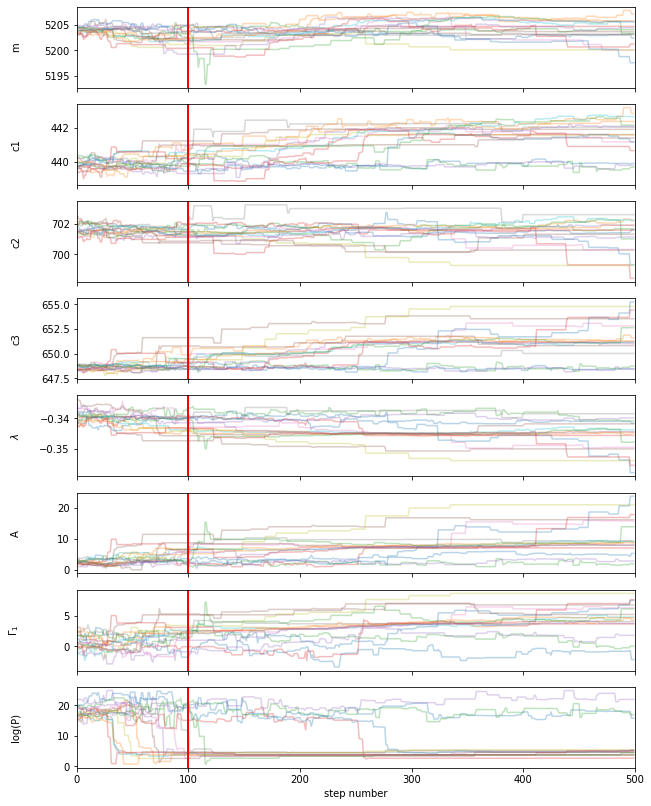

In [86]:
fig, axes = plt.subplots(8, figsize=(10, 14), sharex=True)
labels = ["m", "c1", "c2", "c3", r"$\lambda$", "A", r"$\Gamma_1$", "log(P)"]

for j in range(nwalkers):
    for i in range(ndim):
        ax = axes[i]
        ax.plot(np.arange(0,step_n),samp[j, :, i], alpha=0.3)
        ax.axvline(nburnin, color='red')
        ax.set_xlim(0,step_n)
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Ehh not really converged. Probably cause my priors are poor. I bet my corner plots will be bad

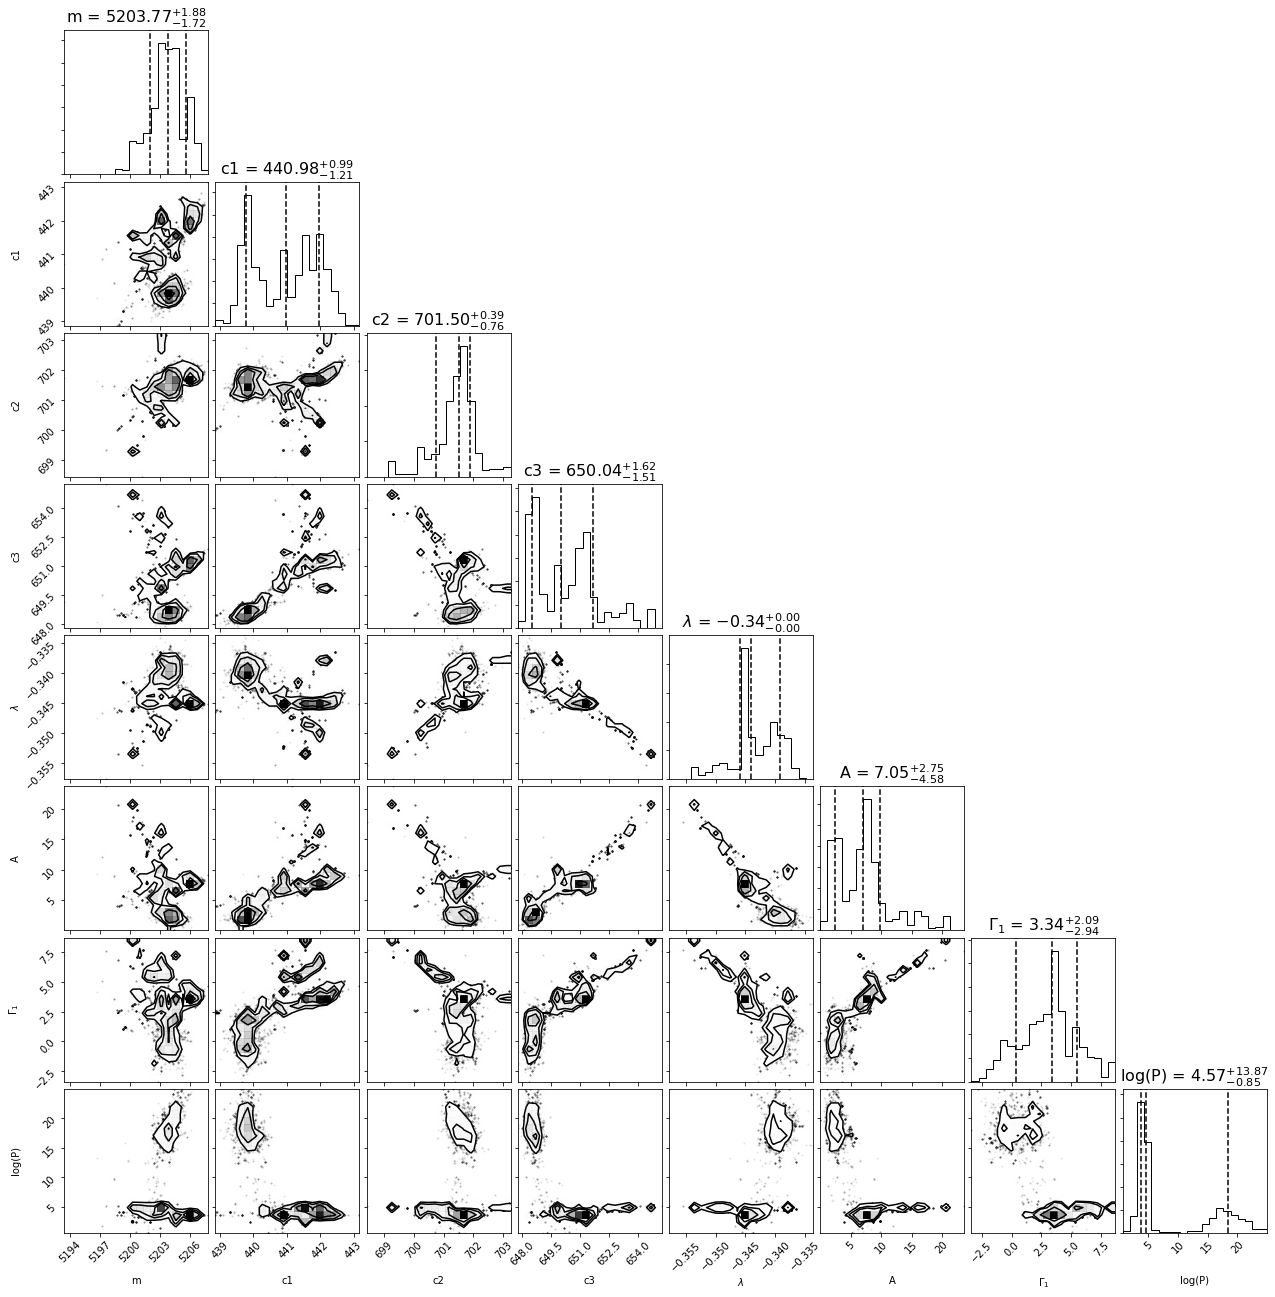

In [87]:
samp = samp.reshape((nwalkers*step_n, ndim))
# make a corner plot
fig = corner.corner(samp, labels=labels, quantiles=[0.16, 0.5, 0.84],\
                       show_titles=True, title_kwargs={"fontsize": 16})

Haha called it :(

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

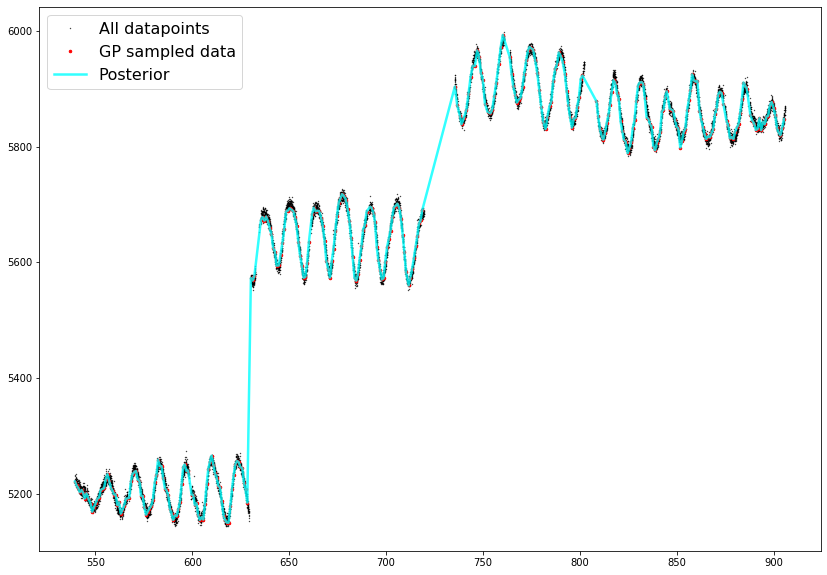

In [88]:
plt.figure(figsize=(14,10))

w_rand = np.random.randint(sampler.chain.shape[0])
n_rand = np.random.randint(sampler.chain.shape[1])
model.set_parameter_vector(sampler.chain[w_rand, n_rand])

plt.plot(t, y, "k.", markersize=.7, label='All datapoints')
plt.plot(t[::40], y[::40], "r.", markersize=5, label='GP sampled data')
plt.plot(t[::40], model.sample_conditional(y[::40], t[::40]), color="cyan", alpha=0.8, lw=2.5, label='Posterior')
plt.legend(loc='best', fontsize=16)

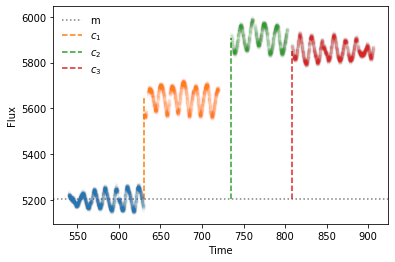

In [89]:
#get normalized  (correcting for offsets data)

qs = sorted(np.unique(tab['quarter']))
means = []
normalized = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
        normalized.append(t['flux'])
    else:

        vmin = means[0]
        vmax = meanflux
        normalized.append(t['flux'] - (vmax-vmin))

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)

normalized = np.concatenate(normalized)

How does my GP work for new (normalized) data??

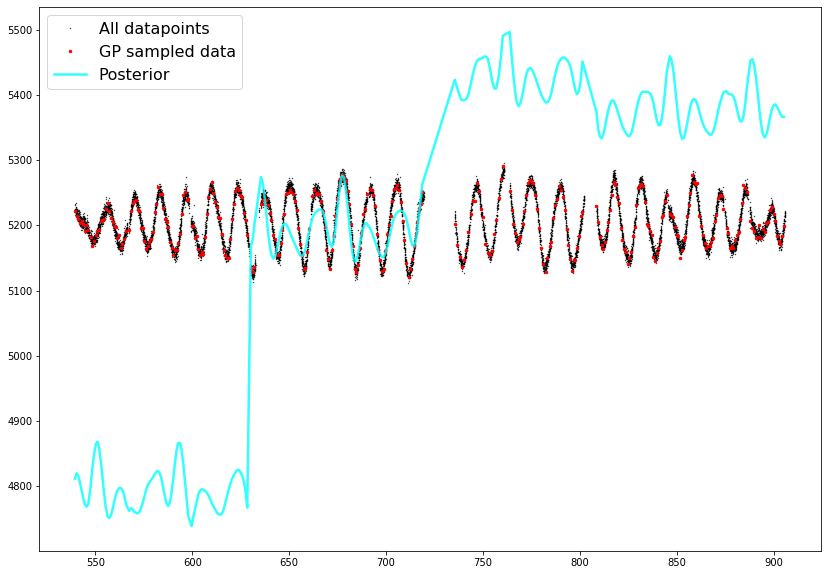

In [98]:
plt.figure(figsize=(14,10))

w_rand = np.random.randint(sampler.chain.shape[0])
n_rand = np.random.randint(sampler.chain.shape[1])
model.set_parameter_vector(sampler.chain[w_rand, n_rand])

plt.plot(t, normalized, "k.", markersize=.7, label='All datapoints')
plt.plot(t[::40], normalized[::40], "r.", markersize=5, label='GP sampled data')
plt.plot(t[::40], model.predict(normalized[::40], t[::40])[0], color="cyan", alpha=0.8, lw=2.5, label='Posterior')
plt.legend(loc='best', fontsize=16)

Eh....there's something wrong with my $m$ and my nuisance params... THEY REALLY ARE A NUISANCE!!!

Do you know what I did wrong??